[View in Colaboratory](https://colab.research.google.com/github/sachinpatkar/ga_revenue_prediction/blob/master/deep_learning_keras_ga_revenue_prediction.v1.ipynb)

## Deep Learning with Keras - Google Analytics Customer Revenue Prediction

*   List item
*   List item


* Note: this is just a starting point, there's a lot of work to be done.
* A begginer version with [LGBM](https://www.kaggle.com/dimitreoliveira/lgbm-google-store-revenue-prediction)

### Loading data google drive

In [0]:
ls -al

total 2916748
drwxr-xr-x 1 root root       4096 Sep 22 20:27 ./
drwxr-xr-x 1 root root       4096 Sep 22 20:21 ../
-rw-r--r-- 1 root root  121693383 Sep 22 20:26 all.zip
drwxr-xr-x 4 root root       4096 Sep 19 23:48 .config/
drwxr-xr-x 2 root root       4096 Sep 20 00:09 sample_data/
---------- 1 root root   14739065 Sep 11 16:45 sample_submission.csv
---------- 1 root root 1346845550 Sep 11 16:45 test.csv
---------- 1 root root 1503430926 Sep 11 16:45 train.csv
-rw-r--r-- 1 root root       3723 Sep 22 20:26 wget-log


In [0]:
!wget https://www.dropbox.com/s/4p74dtbpdf54o5p/all.zip



Redirecting output to ‘wget-log.1’.


In [0]:
ls -l

total 3035588
-rw-r--r-- 1 root root  121693383 Sep 22 20:26 all.zip
-rw-r--r-- 1 root root  121693383 Sep 22 20:45 all.zip.1
drwxr-xr-x 2 root root       4096 Sep 20 00:09 sample_data/
---------- 1 root root   14739065 Sep 11 16:45 sample_submission.csv
---------- 1 root root 1346845550 Sep 11 16:45 test.csv
---------- 1 root root 1503430926 Sep 11 16:45 train.csv
-rw-r--r-- 1 root root       3723 Sep 22 20:26 wget-log
-rw-r--r-- 1 root root       3647 Sep 22 20:45 wget-log.1


In [0]:
!unzip 'all.zip'

Archive:  all.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train.csv               
  inflating: sample_submission.csv   
  inflating: test.csv                


In [0]:
pwd

'/content'

In [0]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

%matplotlib inline
pd.options.display.max_columns = 999

Using TensorFlow backend.


### Auxiliar functions

In [0]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    
    return df


def plot_metrics(loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1, sharex='col', figsize=(20,7))
    ax1.plot(loss, label='Train loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    plt.xlabel('Epochs')

Function to load and convert files borrowed from this [kernel](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook), thanks!

In [0]:
train_csv_path="train.csv"
test_csv_path="test.csv"

In [0]:
ls -al

total 3035600
drwxr-xr-x 1 root root       4096 Sep 22 21:01 ./
drwxr-xr-x 1 root root       4096 Sep 22 20:21 ../
-rw-r--r-- 1 root root  121693383 Sep 22 20:26 all.zip
-rw-r--r-- 1 root root  121693383 Sep 22 20:45 all.zip.1
drwxr-xr-x 4 root root       4096 Sep 19 23:48 .config/
drwxr-xr-x 2 root root       4096 Sep 20 00:09 sample_data/
---------- 1 root root   14739065 Sep 11 16:45 sample_submission.csv
---------- 1 root root 1346845550 Sep 11 16:45 test.csv
---------- 1 root root 1503430926 Sep 11 16:45 train.csv
-rw-r--r-- 1 root root       3723 Sep 22 20:26 wget-log
-rw-r--r-- 1 root root       3647 Sep 22 20:45 wget-log.1


In [0]:
pwd

'/content'

In [0]:
def load_df(train_csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(train_csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    for column in JSON_COLUMNS:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    return df

In [0]:
ls -al

total 3035600
drwxr-xr-x 1 root root       4096 Sep 22 21:01 ./
drwxr-xr-x 1 root root       4096 Sep 22 20:21 ../
-rw-r--r-- 1 root root  121693383 Sep 22 20:26 all.zip
-rw-r--r-- 1 root root  121693383 Sep 22 20:45 all.zip.1
drwxr-xr-x 4 root root       4096 Sep 19 23:48 .config/
drwxr-xr-x 2 root root       4096 Sep 20 00:09 sample_data/
---------- 1 root root   14739065 Sep 11 16:45 sample_submission.csv
---------- 1 root root 1346845550 Sep 11 16:45 test.csv
---------- 1 root root 1503430926 Sep 11 16:45 train.csv
-rw-r--r-- 1 root root       3723 Sep 22 20:26 wget-log
-rw-r--r-- 1 root root       3647 Sep 22 20:45 wget-log.1


In [0]:
train = load_df(train_csv_path)
test = load_df(test_csv_path)

### About the train data

In [0]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,go

### This is how our data looks like

In [0]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 903653
Columns: 50
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flashVersion' 'isMobile'
 'language' 'mobileDeviceBranding' 'mobileDeviceInfo'
 'mobileDeviceMarketingName' 'mobileDeviceModel' 'mobileInputSelector'
 'operatingSystem' 'operatingSystemVersion' 'screenColors'
 'screenResolution' 'city' 'cityId' 'continent' 'country' 'latitude'
 'longitude' 'metro' 'networkDomain' 'networkLocation' 'region'
 'subContinent' 'bounces' 'hits' 'newVisits' 'pageviews'
 'transactionRevenue' 'visits' 'adContent' 'adwordsClickInfo' 'campaign'
 'campaignCode' 'isTrueDirect' 'keyword' 'medium' 'referralPath' 'source']

TEST SET
Rows: 804684
Columns: 48
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserSize' 'browserVersion' 'deviceCategory' 'flash

In [0]:
set(train.columns) - set(test.columns)

{'campaignCode', 'transactionRevenue'}

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 50 columns):
channelGrouping              903653 non-null object
date                         903653 non-null int64
fullVisitorId                903653 non-null object
sessionId                    903653 non-null object
socialEngagementType         903653 non-null object
visitId                      903653 non-null int64
visitNumber                  903653 non-null int64
visitStartTime               903653 non-null int64
browser                      903653 non-null object
browserSize                  903653 non-null object
browserVersion               903653 non-null object
deviceCategory               903653 non-null object
flashVersion                 903653 non-null object
isMobile                     903653 non-null bool
language                     903653 non-null object
mobileDeviceBranding         903653 non-null object
mobileDeviceInfo             903653 non-null object
mobileDevic

In [0]:
train['transactionRevenue'].notNull()

AttributeError: ignored

In [0]:
train = train[pd.notnull(train['transactionRevenue'])]

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 50 columns):
channelGrouping              11515 non-null object
date                         11515 non-null int64
fullVisitorId                11515 non-null object
sessionId                    11515 non-null object
socialEngagementType         11515 non-null object
visitId                      11515 non-null int64
visitNumber                  11515 non-null int64
visitStartTime               11515 non-null int64
browser                      11515 non-null object
browserSize                  11515 non-null object
browserVersion               11515 non-null object
deviceCategory               11515 non-null object
flashVersion                 11515 non-null object
isMobile                     11515 non-null bool
language                     11515 non-null object
mobileDeviceBranding         11515 non-null object
mobileDeviceInfo             11515 non-null object
mobileDeviceMarketingName  

In [0]:
train.drop('campaignCode',axis=1, inplace=True)

### Feature engineering

In [0]:
train = add_time_features(train)
test = add_time_features(test)
# Convert target feature to 'float' type.
train["transactionRevenue"] = train["transactionRevenue"].astype('float')

### Exploratory data analysis

#### Let's take a look at our target value through the time.

In [0]:
time_agg = train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])
year_agg = train.groupby('year')['transactionRevenue'].agg(['sum'])
month_agg = train.groupby('month')['transactionRevenue'].agg(['sum'])
day_agg = train.groupby('day')['transactionRevenue'].agg(['sum'])
weekday_agg = train.groupby('weekday')['transactionRevenue'].agg(['count','sum'])

#### Here is sum of our tagert feature "transactionRevenue" through the time.

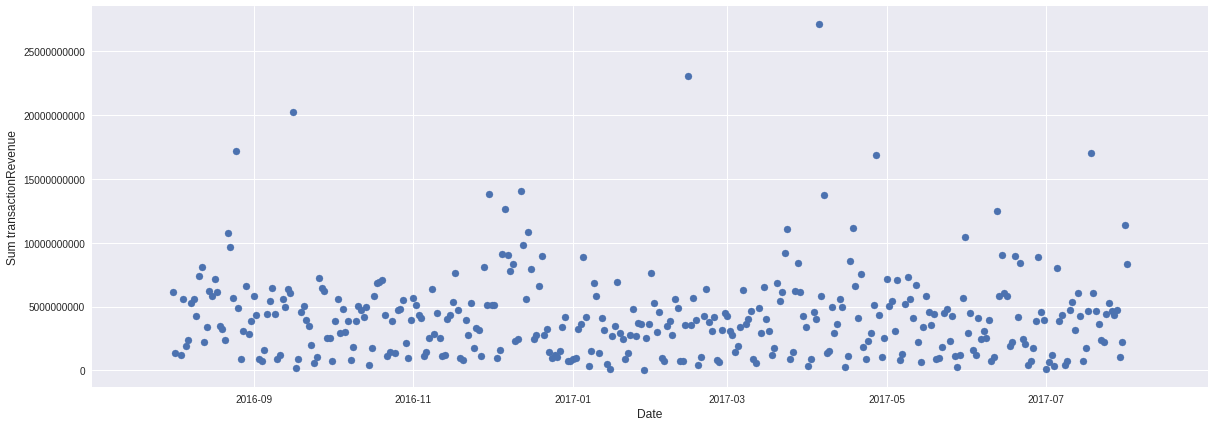

In [0]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

Seems we had more transactions on late 2016 and early 2017, date features seems to be a good addition to our model.

#### And here count of our target feature "transactionRevenue".

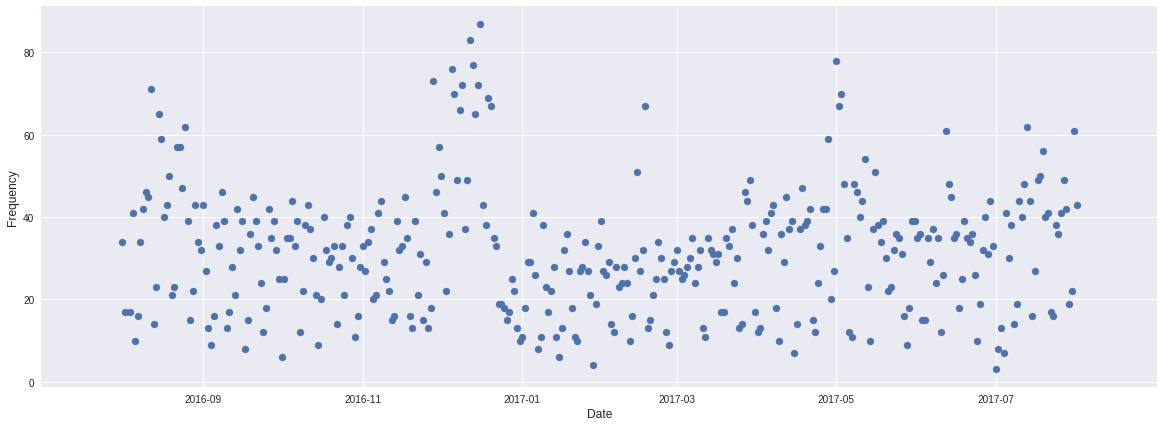

In [0]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

Again we had higher frequency at a similar time period.

#### Let's take a look at other time features.

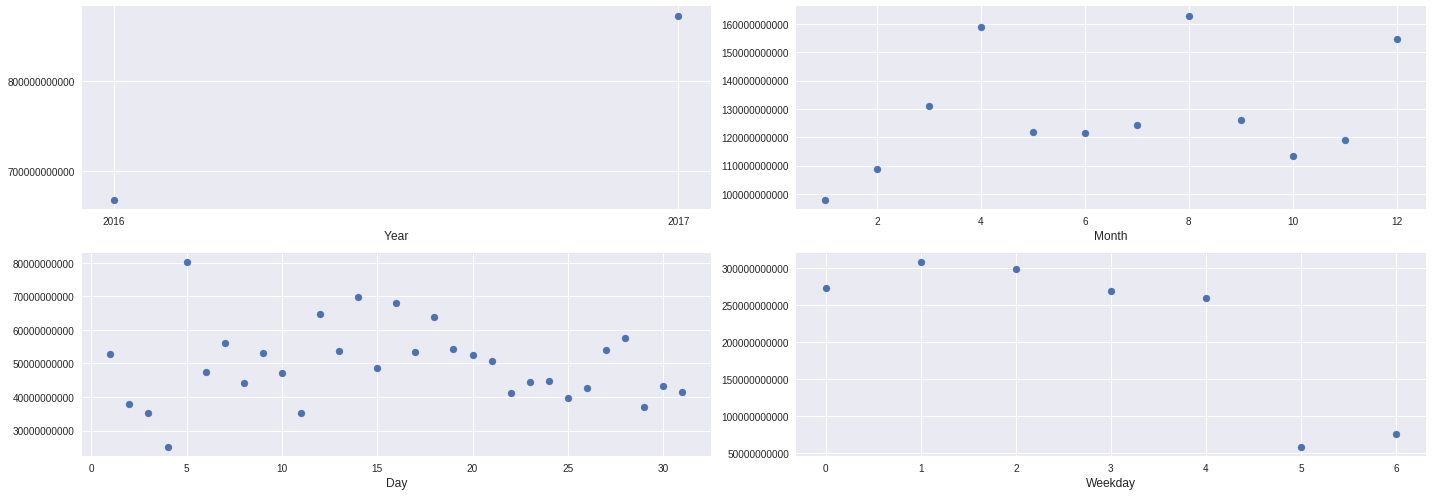

In [0]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
ax1.scatter(year_agg.index.values, year_agg['sum'])
ax1.locator_params(nbins=2)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xlabel('Year', fontsize=12)

ax2.scatter(month_agg.index.values, month_agg['sum'])
ax2.locator_params(nbins=12)
ax2.ticklabel_format(axis='y', style='plain')
ax2.set_xlabel('Month', fontsize=12)

ax3.scatter(day_agg.index.values, day_agg['sum'])
ax3.locator_params(nbins=10)
ax3.ticklabel_format(axis='y', style='plain')
ax3.set_xlabel('Day', fontsize=12)

ax4.scatter(weekday_agg.index.values, weekday_agg['sum'])
ax4.locator_params(nbins=7)
ax4.ticklabel_format(axis='y', style='plain')
ax4.set_xlabel('Weekday', fontsize=12)

plt.tight_layout()
plt.show()

### About the engineered time features
* Year: It seem transactions had a large increase from 2016 to 2017
* Month: Lager transaction on december seems ok, but about months but im not sure why high values on april and august (maybe because of easter (april) or Tax-free weekend, back-to-school season(august)?)
* Day: Here it seems that not really important is going on, seems this features can be discarded.
* Weekday: Something strange is going on here, seems that weekends have less transactions?

### The let's do some cleaning

### Drop unwanted columns

In [0]:
# Unwanted columns
unwanted_columns = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', 
                    'browser', 'browserSize', 'browserVersion', 'flashVersion', 
                    'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 
                    'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 
                    'metro','networkDomain', 'networkLocation', 'adContent', 'campaign', 
                    'isTrueDirect', 'keyword', 'referralPath', 'source', 'operatingSystem', 'day','adwordsClickInfo']

train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)


In [0]:
# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)



Columns with constant values:  ['socialEngagementType', 'language', 'mobileDeviceBranding', 'screenResolution', 'cityId', 'latitude', 'longitude', 'bounces', 'newVisits', 'visits']


In [0]:
train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)
# Columns with more than 50% null data
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns more than 50% null values: ', high_null_columns)
train = train.drop(high_null_columns, axis=1)
test = test.drop(high_null_columns, axis=1)

ValueError: ignored

### This is our new data with some cleaning and engineering.

In [0]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 11515
Columns: 17
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'city'
 'continent' 'country' 'region' 'subContinent' 'hits' 'pageviews'
 'transactionRevenue' 'medium' 'year' 'month' 'weekday']

TEST SET
Rows: 804684
Columns: 16
Features: ['channelGrouping' 'date' 'visitNumber' 'deviceCategory' 'isMobile' 'city'
 'continent' 'country' 'region' 'subContinent' 'hits' 'pageviews' 'medium'
 'year' 'month' 'weekday']


In [0]:
train.head()

,channelGrouping,date,visitNumber,deviceCategory,isMobile,city,continent,country,region,subContinent,hits,pageviews,transactionRevenue,medium,year,month,weekday
752,Direct,2016-09-02,1,desktop,False,Ann Arbor,Americas,United States,Michigan,Northern America,11,11,37860000.0,(none),2016,9,4
753,Organic Search,2016-09-02,3,desktop,False,New York,Americas,United States,New York,Northern America,11,10,306670000.0,organic,2016,9,4
799,Referral,2016-09-02,7,desktop,False,New York,Americas,United States,New York,Northern America,13,11,68030000.0,referral,2016,9,4
802,Referral,2016-09-02,6,desktop,False,Mountain View,Americas,United States,California,Northern America,13,12,26250000.0,referral,2016,9,4
859,Referral,2016-09-02,4,desktop,False,not available in demo dataset,Americas,United States,not available in demo dataset,Northern America,17,14,574150000.0,referral,2016,9,4


### One-hot encode categorical data

In [0]:
categorical_features = ['deviceCategory', 'isMobile', 'continent', 'month', 'weekday']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

In [0]:
# align both data sets (by outer join), to make they have the same amount of features,
# this is required because of the mismatched categorical values in train and test sets
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

### Split data in train and validation by date
* This time based split will result in approximated 85% train and 15% validation.

In [0]:
X_train = train[train['date']<=datetime.date(2017, 5, 31)]
X_val = train[train['date']>datetime.date(2017, 5, 31)]

In [0]:
# Get labels
Y_train = X_train['transactionRevenue'].values
Y_val = X_val['transactionRevenue'].values
X_train = X_train.drop(['transactionRevenue'], axis=1)
X_val = X_val.drop(['transactionRevenue'], axis=1)
test = test.drop(['transactionRevenue'], axis=1)
# Log transform the labels
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

In [0]:
reduce_features = ['city', 'medium', 'channelGrouping', 
                    'region', 'subContinent', 'country', 'date']
X_train = X_train.drop(reduce_features, axis=1)
X_val = X_val.drop(reduce_features, axis=1)
test = test.drop(reduce_features, axis=1)

### Normalize the data

In [0]:
normalized_features = ['visitNumber', 'hits', 'pageviews']

# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
X_train[normalized_features] = scaler.fit_transform(X_train[normalized_features])
X_val[normalized_features] = scaler.transform(X_val[normalized_features])
test[normalized_features] = scaler.transform(test[normalized_features])

In [0]:
X_train.head()

### Model
* Now let's try some deep learning to model our data.

In [0]:
BATCH_SIZE = 64
EPOCHS = 70
LEARNING_RATE = 0.0001

In [0]:
model = Sequential()
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

In [0]:
adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

In [0]:
print('Dataset size: %s' % X_train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % X_train.shape[1])
print('Features used: %s' % train.columns.values)

In [0]:
model.summary()

In [0]:
history = model.fit(x=X_train.values, y=Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_val.values, Y_val))

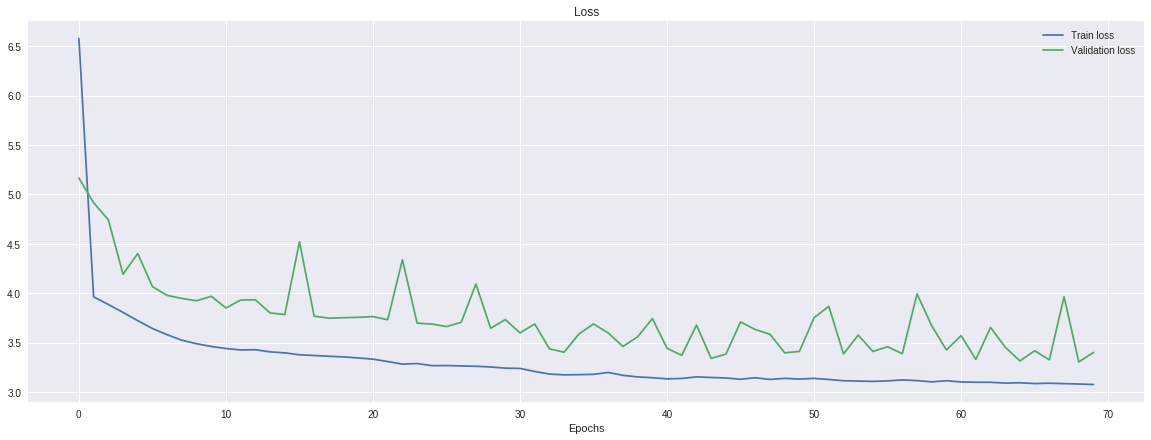

In [0]:
plot_metrics(history.history['loss'], history.history['val_loss'])

In [0]:
predictions = model.predict(test)

submission = pd.DataFrame({"fullVisitorId":test_ids})
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
# submission["PredictedLogRevenue"] = np.expm1(predictions)
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
# submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.to_csv("submission.csv", index=False)

In [0]:
submission.head(10)